In [330]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [413]:
tasks_fn = 'resources/house_target_tuple.json'
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_dir = '../tasks/instruction_following/'
dialog_navigation_dir = '../tasks/dialog_navigation/'
folds = ["train", "val_seen", "val_unseen", "test"]

with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)

In [414]:
# Enumerate distances inside of task tuple data.
task_ds = []
targets = set()
for house in house_target_tuple:
    for target, _, _, _, end_pano_ds in house_target_tuple[house]:
        task_ds.append(min(end_pano_ds))
        targets.add(target)
print("Read in %d possible tuples (%d targets)" % (len(task_ds), len(targets)))

Read in 1629 possible tuples (81 targets)


In [415]:
# Enumrate distances inside of matterport R2R data.
mp_ds = []
scans = set()
mp_paths_per_scan = {}
for fn in ['../../../tasks/R2R/data/R2R_train.json',
           '../../../tasks/R2R/data/R2R_val_seen.json',
           '../../../tasks/R2R/data/R2R_val_unseen.json']:
    with open(fn, 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        mp_ds.append(len(trajectory['path']))
        scan = trajectory['scan']
        scans.add(scan)
        if scan not in mp_paths_per_scan:
            mp_paths_per_scan[scan] = []
        mp_paths_per_scan[scan].append(trajectory['path'])
with open('../../../tasks/R2R/data/R2R_test.json', 'r') as f:
    mp_data = json.load(f)
for trajectory in mp_data:
    scans.add(trajectory['scan'])
print("MP R2R total trajs: %d (%d annotations) (%d scans)" % (len(mp_ds), 3*len(mp_ds), len(scans)))

MP R2R total trajs: 5798 (17394 annotations) (90 scans)


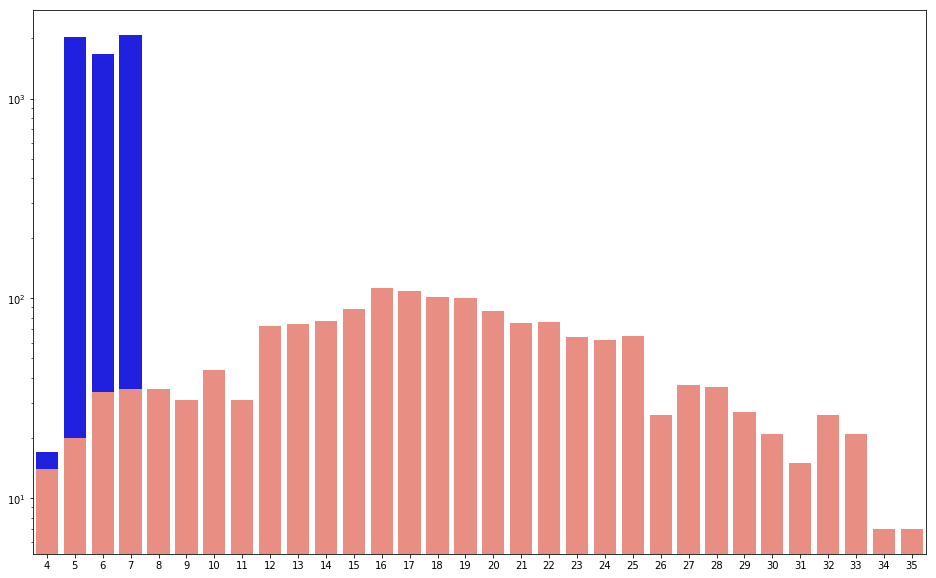

MPD average hops:	18.21+/-6.68, (n=1629)
MP R2R average hops:	6.00+/-0.85, (n=5798)


In [416]:
# Visualize tuple path distances.
bin_size = 1

freq_of_task_ds_count_bins = {}
for c in task_ds:
    cbin = c // bin_size
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0
    freq_of_task_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_task_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_task_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0

fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_mp_ds_count_bins],
                 y=[freq_of_mp_ds_count_bins[k] for k in freq_of_mp_ds_count_bins],
                 color="blue")
g2 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_task_ds_count_bins],
                 y=[freq_of_task_ds_count_bins[k] for k in freq_of_task_ds_count_bins],
                 color="salmon")
ax.set(yscale="log")
plt.show()

print("MPD average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(task_ds), np.std(task_ds), len(task_ds)))
print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))

In [417]:
# Load games data and strip non-successes.
with open(games_fn, 'r') as f:
    games = pd.read_json(json.load(f))

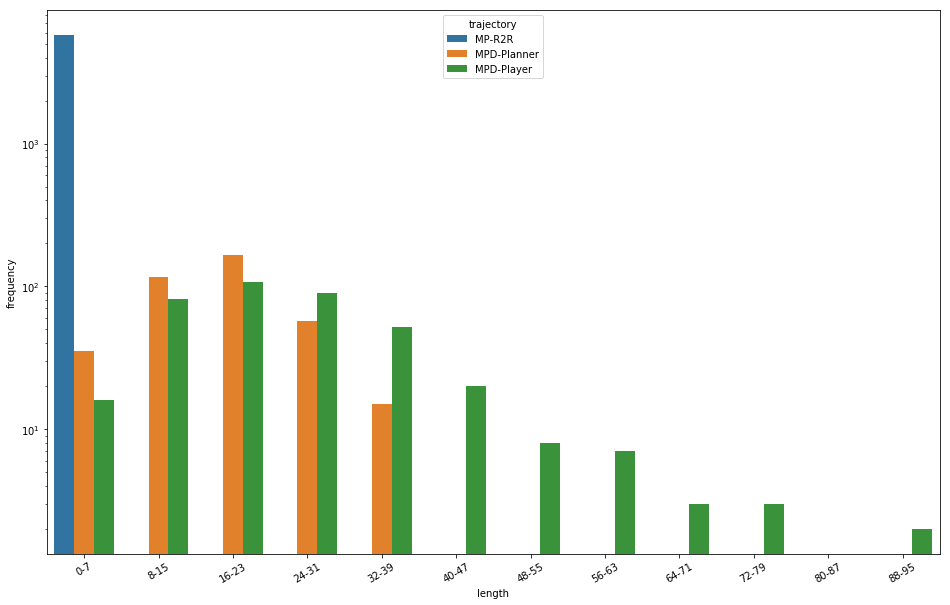

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD Player average hops:	24.90+/-13.68, (n=391)
MPD Planner average hops:	17.24+/-6.93, (n=391)


In [418]:
# Examine distribution of dialog navigation lengths versus MatterPort.
bin_size = 8

ins_ds = [len(games['planner_nav_steps'][idx]) for idx in games.index]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(games['nav_steps'][idx]) for idx in games.index]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
if bin_size > 1:
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [419]:
# Load dialog data.
dialog = []
dialog_fold = {}
fold_to_scans = {}
print("fold, instances, scans")
for fold in folds:
    with open(os.path.join(dialog_navigation_dir, "%s.json" % fold), 'r') as f:
        fold_trajs = json.load(f)
        fold_scans = set([traj['scan'] for traj in fold_trajs])
        dialog.extend(fold_trajs)
        print("%s, %d, %d" % (fold, len(fold_trajs), len(fold_scans)))
    for scan in fold_scans:
        dialog_fold[scan] = fold
    fold_to_scans[fold] = fold_scans

fold, instances, scans
train, 244, 57
val_seen, 16, 15
val_unseen, 56, 10
test, 75, 16


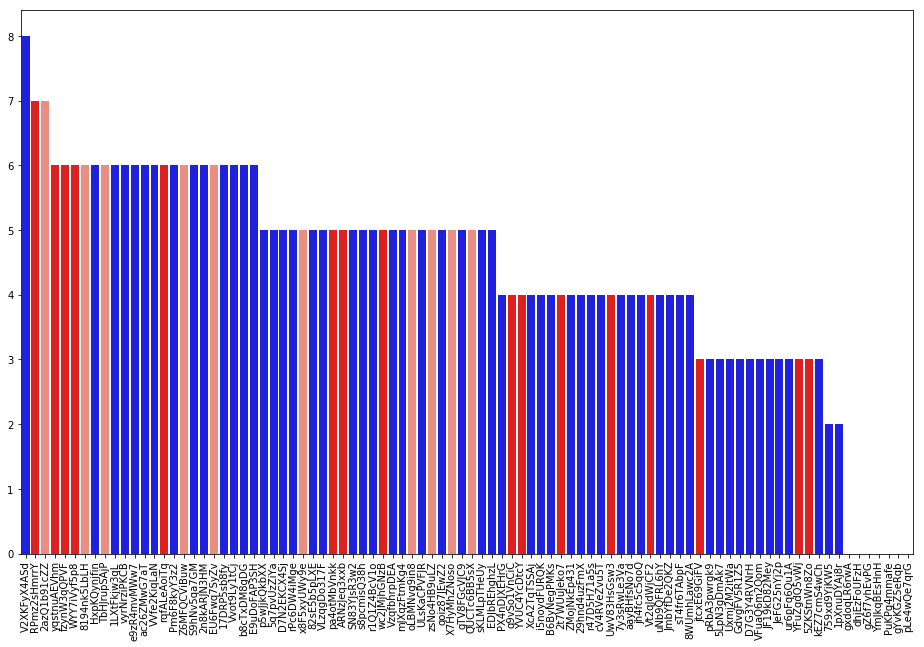

No data for 4/81 targets:
	['chandelier', 'coatrack', 'sconce', 'teapot']


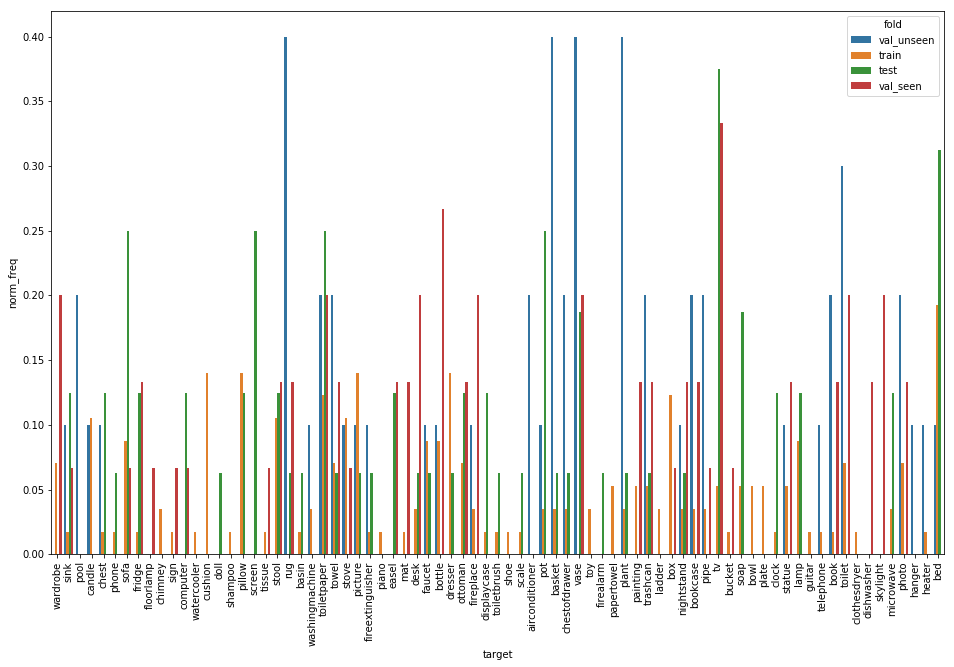

In [420]:
# Visualize game coverage across houses and target objects.

values = list(scans)
counts = {v: len([dn for dn in dialog if dn['scan'] == v])
          for v in values}
ordered = sorted(counts.items(), key=lambda x: x[1], reverse=True)

fold_to_color = {"train": 'blue',
                 "val_seen": 'blue',  # train/val seen are the same set of scans
                 "val_unseen": 'salmon',
                 "test": 'red'}
fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax, x=[o[0] for o in ordered], y=[o[1] for o in ordered],
                order=[o[0] for o in ordered],
                palette=[fold_to_color[dialog_fold[o[0]]]
                         if o[0] in dialog_fold else 'black'
                         for o in ordered])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

values = list(targets)
counts = {v: len([dn for dn in dialog if dn['target'] == v])
          for v in values}

empty_targets = [t for t in targets if counts[t] == 0]
print("No data for %d/%d targets:\n\t" % (len(empty_targets), len(targets)) + str(empty_targets))
d = []
for fold in fold_to_color:
    d.extend([{'target': target,
               'frequency': len([dn for dn in dialog if dn['target'] == target and dialog_fold[dn['scan']] == fold]),
               'norm_freq': len([dn for dn in dialog if dn['target'] == target and dialog_fold[dn['scan']] == fold]) / len(fold_to_scans[fold]),
               'fold': fold,}
              for target in targets if target not in empty_targets])
ordered = sorted(counts.items(), key=lambda x: x[1], reverse=True)

fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='target', y='norm_freq', hue="fold", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

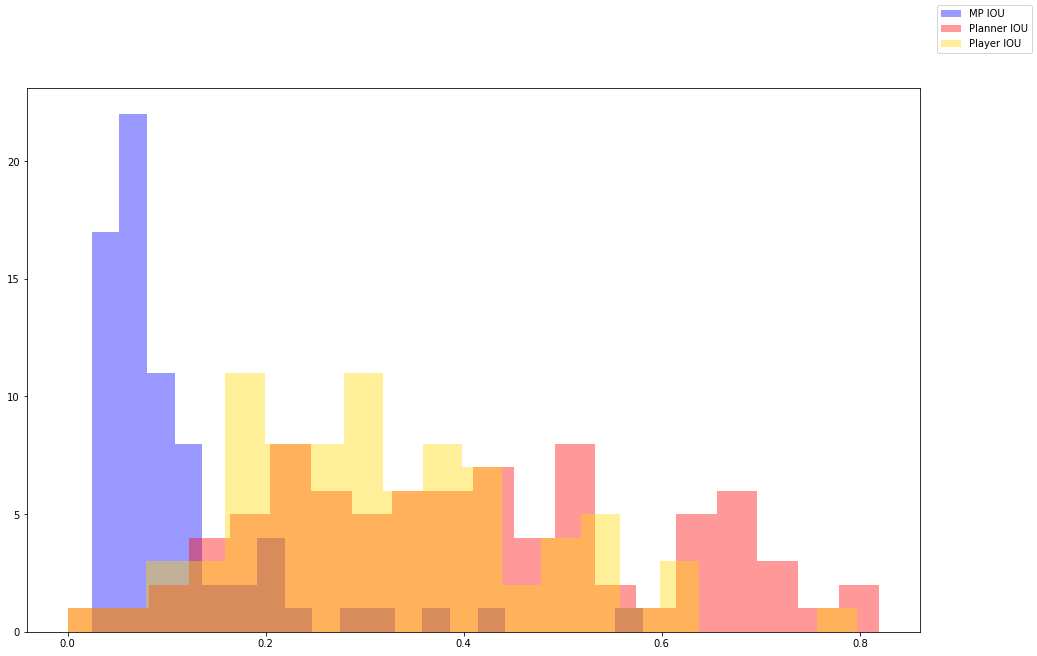

In [421]:
# Examine average path overlap.
planner_paths_per_scan = {}
player_paths_per_scan = {}
for idx in games.index:
    scan = games['scan'][idx]
    planner_path = games['planner_nav_steps'][idx]
    player_path = games['nav_steps'][idx]
    if scan not in planner_paths_per_scan:
        planner_paths_per_scan[scan] = []
        player_paths_per_scan[scan] = []
    planner_paths_per_scan[scan].append(planner_path)
    player_paths_per_scan[scan].append(player_path)

avg_planner_iou_per_scan = {}
avg_player_iou_per_scan = {}
avg_mp_iou_per_scan = {}
for scan in scans:
    if scan in planner_paths_per_scan:
        planner_iou_per_path_pair = 0
        player_iou_per_path_pair = 0
        num_path_pairs = 0
        for idx in range(len(planner_paths_per_scan[scan])):
            for jdx in range(idx + 1, len(planner_paths_per_scan[scan])):
                planner_iou_per_path_pair += (len(set(planner_paths_per_scan[scan][idx]).intersection(
                    set(planner_paths_per_scan[scan][jdx]))) / len(set(planner_paths_per_scan[scan][idx]).union(
                    set(planner_paths_per_scan[scan][jdx]))))
                player_iou_per_path_pair += (len(set(player_paths_per_scan[scan][idx]).intersection(
                    set(player_paths_per_scan[scan][jdx]))) / len(set(player_paths_per_scan[scan][idx]).union(
                    set(player_paths_per_scan[scan][jdx]))))
                num_path_pairs += 1
        planner_iou_per_path_pair /= num_path_pairs
        player_iou_per_path_pair /= num_path_pairs
        avg_planner_iou_per_scan[scan] = planner_iou_per_path_pair
        avg_player_iou_per_scan[scan] = player_iou_per_path_pair
    
    if scan in mp_paths_per_scan:
        mp_iou_per_path_pair = 0
        mp_path_pairs = 0
        for idx in range(len(mp_paths_per_scan[scan])):
            for jdx in range(idx + 1, len(mp_paths_per_scan[scan])):
                mp_iou_per_path_pair += (len(set(mp_paths_per_scan[scan][idx]).intersection(
                    set(mp_paths_per_scan[scan][jdx]))) / len(set(mp_paths_per_scan[scan][idx]).union(
                    set(mp_paths_per_scan[scan][jdx]))))
                mp_path_pairs += 1
        mp_iou_per_path_pair /= mp_path_pairs
        avg_mp_iou_per_scan[scan] = mp_iou_per_path_pair

nbins = 20
fig, ax = plt.subplots(figsize=(16, 10))
sns.distplot(np.array([avg_mp_iou_per_scan[s] for s in avg_mp_iou_per_scan]),
             color="blue", label="MP IOU", kde=False, bins=nbins)
sns.distplot(np.array([avg_planner_iou_per_scan[s] for s in avg_planner_iou_per_scan]),
             color="red", label="Planner IOU", kde=False, bins=nbins)
sns.distplot(np.array([avg_player_iou_per_scan[s] for s in avg_player_iou_per_scan]),
             color="gold", label="Player IOU", kde=False, bins=nbins)
fig.legend()
plt.show()

Games 129, suspicious player performance 14 < 16 (1.14)
Games 243, suspicious player performance 13 < 14 (1.08)
Games 29, suspicious player performance 6 < 8 (1.33)
Games 345, suspicious player performance 17 < 18 (1.06)
Games 351, suspicious player performance 15 < 16 (1.07)
Games 40, suspicious player performance 20 < 21 (1.05)
Games 46, suspicious player performance 6 < 8 (1.33)
Games 97, suspicious player performance 14 < 16 (1.14)


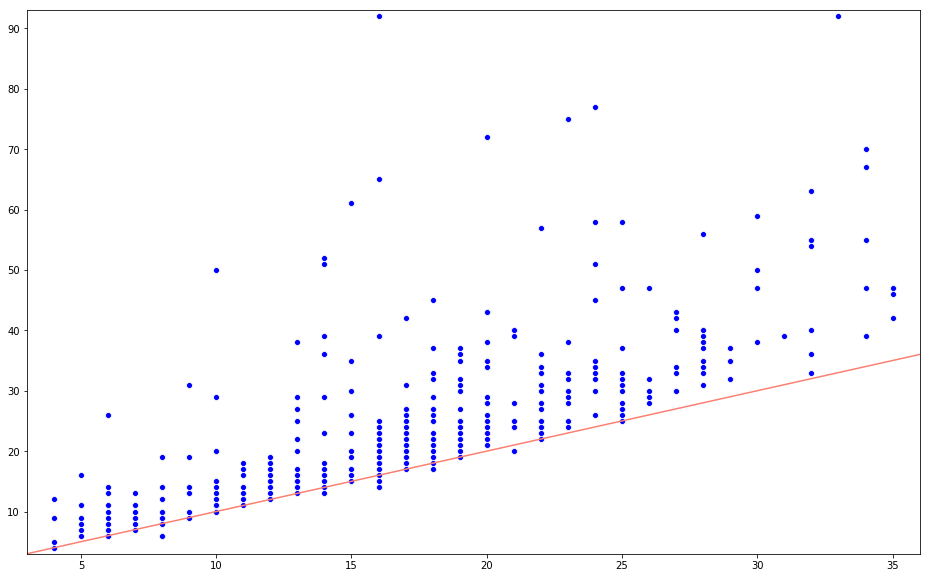

In [422]:
# Nav lengths against shortest path for completed games.
player_lens = []
shortest_lens = []
for idx in games.index:
    player_traj_len = len(games['nav_steps'][idx])
    shortest_traj_len = None
    for obj, start_pano, _, end_panos, end_pano_ds in house_target_tuple[games['scan'][idx]]:
        if (start_pano == games['start_pano'][idx] and
                obj == games['target'][idx] and
                set(end_panos) == set(games['end_panos'][idx])):
            shortest_traj_len = min(end_pano_ds)
    if shortest_traj_len is not None:
        if shortest_traj_len > player_traj_len:
            print("Games %d, suspicious player performance %d < %d (%.2f)" % 
                  (idx, player_traj_len, shortest_traj_len, float(shortest_traj_len / player_traj_len)))
        player_lens.append(player_traj_len)
        shortest_lens.append(shortest_traj_len)
    else:
        print("WARNING: task for house %s, target '%s' missing" % (games['scan'][idx], games['target'][idx]))
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=shortest_lens, y=player_lens, color='blue')
g2 = sns.lineplot(ax=ax, x=[min(shortest_lens) - 1, max(shortest_lens) + 1],
                  y=[min(shortest_lens) - 1, max(shortest_lens) + 1], color='salmon')  # Perfect
ax.set(xlim=(min(shortest_lens) - 1, max(shortest_lens) + 1),
       ylim=(min(player_lens) - 1, max(player_lens) + 1))
plt.show()

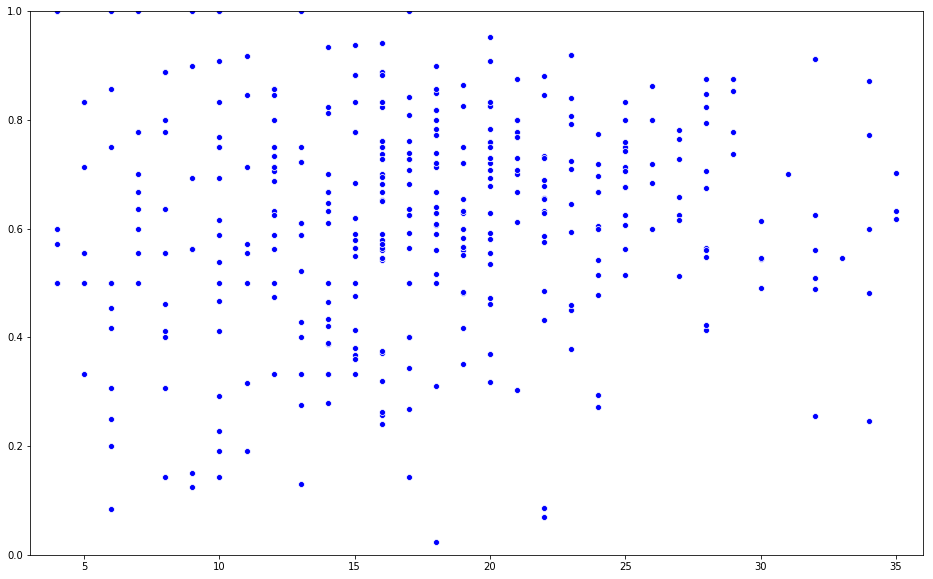

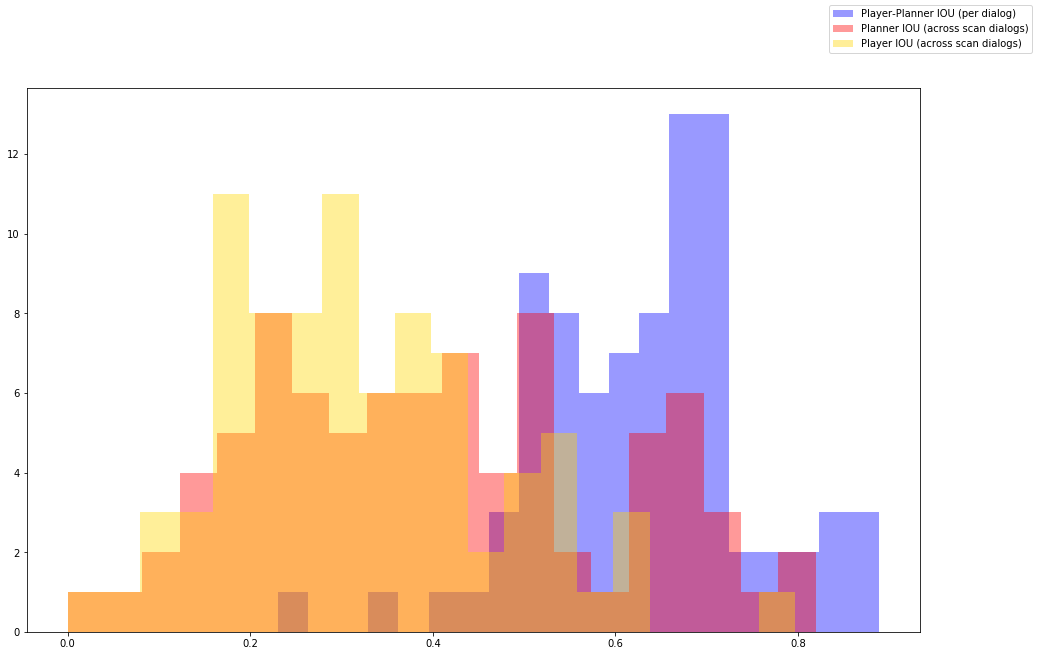

In [438]:
# IOU of player paths versus planner paths.
path_ious = []
shortest_lens = []
for scan in planner_paths_per_scan:
    for idx in range(len(planner_paths_per_scan[scan])):
        path_ious.append(len(set(planner_paths_per_scan[scan][idx]).intersection(
            set(player_paths_per_scan[scan][idx]))) / len(set(planner_paths_per_scan[scan][idx]).union(
            set(player_paths_per_scan[scan][idx]))))
        shortest_lens.append(len(planner_paths_per_scan[scan][idx]))
        
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=shortest_lens, y=path_ious, color='blue')
g2 = sns.lineplot(ax=ax, x=[min(shortest_lens) - 1, max(shortest_lens) + 1],
                  y=[min(shortest_lens) - 1, max(shortest_lens) + 1], color='salmon')  # Perfect
ax.set(xlim=(min(shortest_lens) - 1, max(shortest_lens) + 1),
       ylim=(0, 1))
plt.show()

nbins = 20
fig, ax = plt.subplots(figsize=(16, 10))
sns.distplot(np.array([path_iou_per_scan[s] for s in path_iou_per_scan]),
             color="blue", label="Player-Planner IOU (per dialog)", kde=False, bins=nbins)
sns.distplot(np.array([avg_planner_iou_per_scan[s] for s in avg_planner_iou_per_scan]),
             color="red", label="Planner IOU (across scan dialogs)", kde=False, bins=nbins)
sns.distplot(np.array([avg_player_iou_per_scan[s] for s in avg_player_iou_per_scan]),
             color="gold", label="Player IOU (across scan dialogs)", kde=False, bins=nbins)
fig.legend()
plt.show()

26	7	(3.71)
14	7	(2.00)
13	1	(13.00)
33	5	(6.60)
27	5	(5.40)
23	11	(2.09)
43	5	(8.60)
26	7	(3.71)
24	15	(1.60)
26	7	(3.71)
23	7	(3.29)
35	11	(3.18)
56	13	(4.31)
22	21	(1.05)
22	5	(4.40)
29	7	(4.14)
17	9	(1.89)
27	5	(5.40)
25	3	(8.33)
12	5	(2.40)
30	9	(3.33)
19	7	(2.71)
8	3	(2.67)
18	3	(6.00)
25	5	(5.00)
24	7	(3.43)
21	7	(3.00)
18	7	(2.57)
11	5	(2.20)
15	7	(2.14)
34	5	(6.80)
39	5	(7.80)
29	11	(2.64)
50	11	(4.55)
14	7	(2.00)
55	11	(5.00)
15	5	(3.00)
8	5	(1.60)
40	13	(3.08)
9	7	(1.29)
23	7	(3.29)
42	13	(3.23)
11	3	(3.67)
21	5	(4.20)
35	9	(3.89)
20	7	(2.86)
29	13	(2.23)
29	9	(3.22)
25	11	(2.27)
20	7	(2.86)
67	27	(2.48)
10	5	(2.00)
63	15	(4.20)
18	9	(2.00)
18	9	(2.00)
37	13	(2.85)
36	9	(4.00)
39	3	(13.00)
34	13	(2.62)
51	23	(2.22)
24	1	(24.00)
17	9	(1.89)
16	9	(1.78)
39	17	(2.29)
9	5	(1.80)
27	9	(3.00)
24	9	(2.67)
25	7	(3.57)
9	7	(1.29)
47	9	(5.22)
77	13	(5.92)
17	9	(1.89)
70	15	(4.67)
17	7	(2.43)
7	3	(2.33)
17	7	(2.43)
61	11	(5.55)
6	5	(1.20)
23	7	(3.29)
8	1	(8.00)
92	25	(3.68)
18	11	(1.64

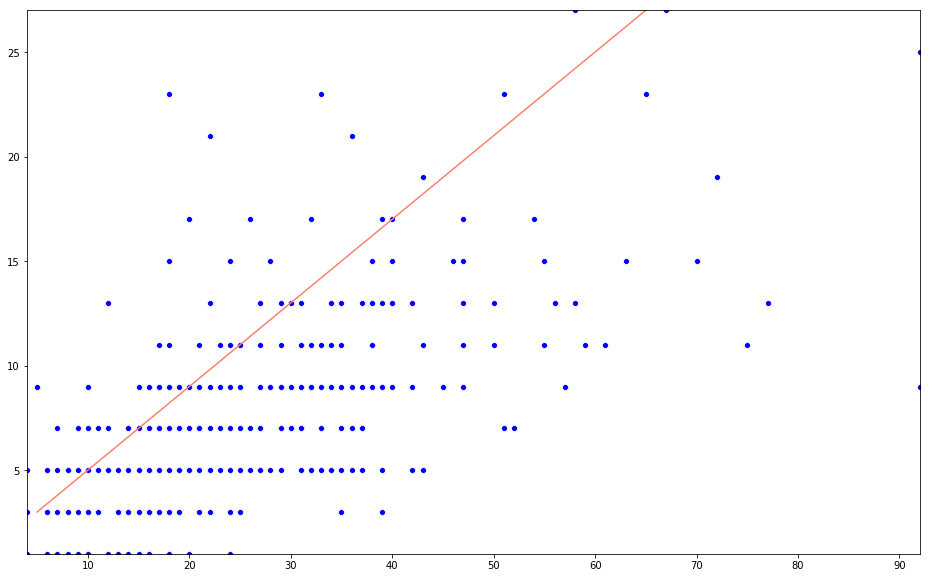

In [424]:
# Nav lengths against dialog lengths for completed games
nav_lens = []
dialog_lens = []
for idx in games.index:
    nav_len = len(games['nav_steps'][idx])
    dialog_len = len(games['dialog_history'][idx]) + 1  # Counts the initial "hint" as a turn to avoid div by zero
    print("%d\t%d\t(%.2f)" % (nav_len, dialog_len, float(nav_len / dialog_len)))
    nav_lens.append(nav_len)
    dialog_lens.append(dialog_len)
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=nav_lens, y=dialog_lens, color='blue')
# "Conservative", asking 1 question every 5 nav turns, gives 2 dialog turns per 5 nav, with an offset of +1 for hint.
g2 = sns.lineplot(ax=ax, x=[5, 5*max(dialog_lens)], y=[2+1, (2*max(dialog_lens))+1], color='salmon')
ax.set(xlim=(min(nav_lens), max(nav_lens)), ylim=(min(dialog_lens), max(dialog_lens)))
plt.show()

In [439]:
# Load instruction following data.
ins_follow = []
print("fold, instances, scans")
for fold in folds:
    with open(os.path.join(instruction_following_dir, "%s.json" % fold), 'r') as f:
        fold_trajs = json.load(f)
        fold_scans = set([traj['scan'] for traj in fold_trajs])
        ins_follow.extend(fold_trajs)
        print("%s, %d, %d" % (fold, len(fold_trajs), len(fold_scans)))

fold, instances, scans
train, 707, 57
val_seen, 46, 12
val_unseen, 168, 10
test, 240, 16


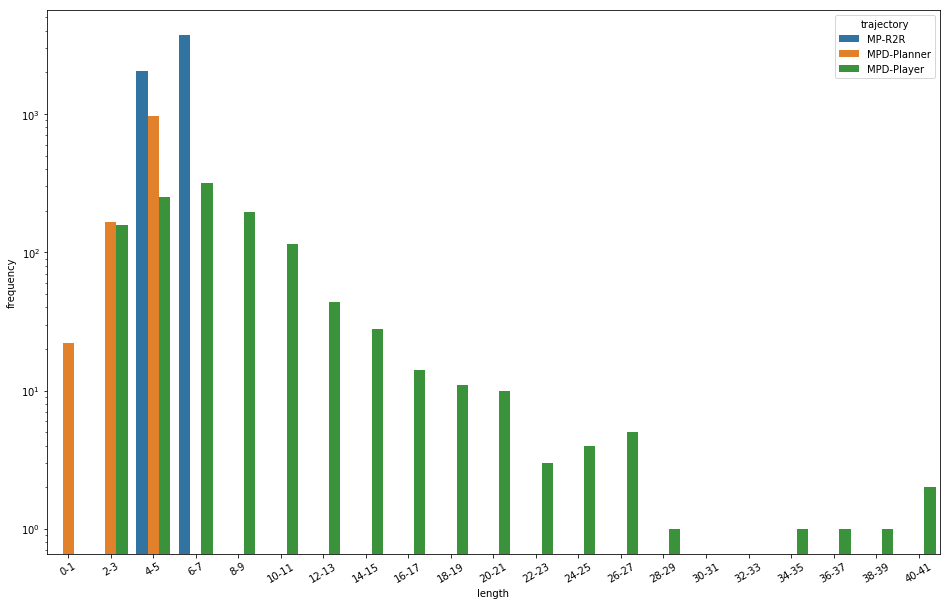

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD IF Player average hops:	7.37+/-4.47, (n=1161)
MPD IF Planner average hops:	4.48+/-1.04, (n=1161)


In [440]:
# Examine distribution of instruction following lengths versus MatterPort.
bin_size = 2

ins_ds = [len(task['planner_path']) for task in ins_follow]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(task['player_path']) for task in ins_follow]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
if bin_size > 1:
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD IF Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD IF Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [441]:
# Examine human performance on the instruction following and dialog tasks based on official R2R metrics.
ins_sr = sum([ins_follow[idx]['R2R_success'] for idx in range(len(ins_follow))]) / len(ins_follow)
ins_osr = sum([ins_follow[idx]['R2R_oracle_success'] for idx in range(len(ins_follow))]) / len(ins_follow)
ins_spl = sum([ins_follow[idx]['R2R_spl'] for idx in range(len(ins_follow))]) / len(ins_follow)
ins_ospl = sum([ins_follow[idx]['R2R_oracle_spl'] for idx in range(len(ins_follow))]) / len(ins_follow)
print(ins_sr, ins_osr, ins_spl, ins_ospl)

dia_spl = sum(games['R2R_spl']) / len(games)
dia_ospl = sum(games['R2R_oracle_spl']) / len(games)
print(dia_spl, dia_ospl)

0.47114556416882 0.8880275624461671 0.10480735843189626 0.45454559801067257
0.04739858941329919 0.08224671568158574
